## Xマッチからブキ偏差値を求める

In [26]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from scipy.stats import boxcox
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 6, 17)
date_to = dt.date(2023, 6, 30)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)

バトル数: 19571


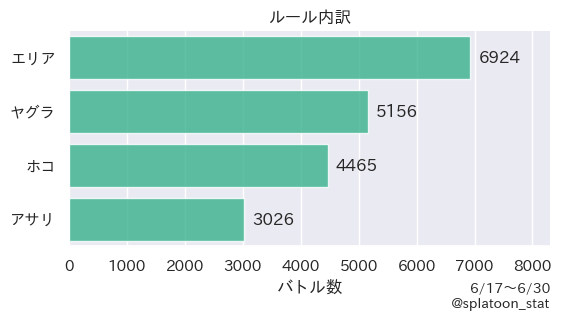

パワー不明バトル数: 1636


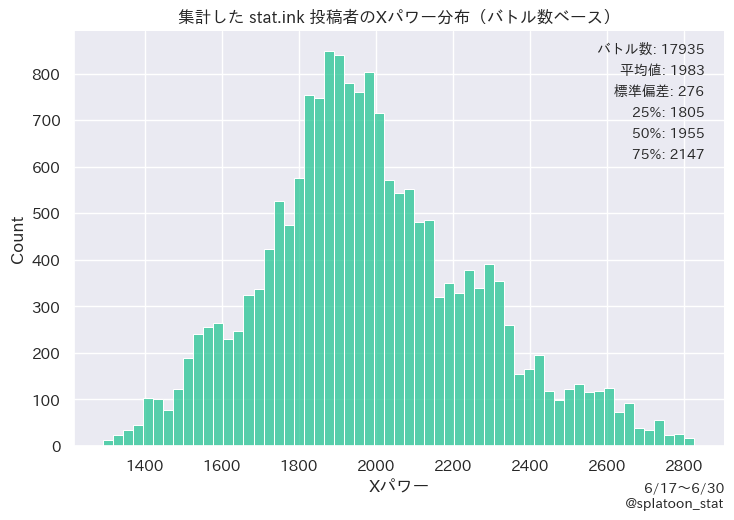

In [27]:
v.xmatch_mode_breakdown(battles=battles, locale=locale)
v.xmatch_power_distribution(battles=battles, locale=locale)

In [28]:
players = u.to_players(battles)

### ブキ統計値を求める

- ブキ使用率
- ブキ使用者の平均Xパワー

In [29]:
usage = players.groupby("mode")["weapon"].value_counts(normalize=True).to_frame("usage")
power = players.groupby(["mode", "weapon"])["power"].mean().to_frame("power")

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

weapon_stat = pd.concat([usage, power], axis=1)
weapon_stat["usage-bc"] = weapon_stat.groupby("mode")["usage"].transform(lambda x: boxcox(x)[0])
weapon_stat["usage-z"] = weapon_stat.groupby("mode", group_keys=False)["usage-bc"].apply(standardize)
weapon_stat["power-z"] = weapon_stat.groupby("mode", group_keys=False)["power"].apply(standardize)

k_coef = 0.45
theta = np.pi / 2 * k_coef
vec_strength = np.array([np.cos(theta), np.sin(theta)])

def calc_dot(series: pd.Series) -> float:
    vec_weapon = np.array([series["usage-z"], series["power-z"]])
    return np.dot(vec_weapon, vec_strength)

weapon_stat["strength"] = weapon_stat.apply(calc_dot, axis=1)
weapon_stat["strength-z"] = standardize(weapon_stat["strength"])
weapon_stat["strength-t"] = weapon_stat["strength-z"].map(lambda x: x * 10 + 50)
weapon_stat

usage        power  usage-bc   usage-z   power-z  \
mode   weapon                                                                  
area   sshooter_collabo  0.052860  1906.282315 -2.240330  2.125583 -1.202100   
       sharp             0.044153  2072.329840 -2.340284  1.898720  0.770349   
       sharp_neo         0.043761  2015.646472 -2.345147  1.887683  0.097018   
       wakaba            0.041533  1947.833804 -2.373474  1.823392 -0.708517   
       liter4k           0.038314  2028.512810 -2.416635  1.725431  0.249855   
...                           ...          ...       ...       ...       ...   
yagura l3reelgun         0.000804  2017.142857 -4.413829 -1.737442  0.796692   
       campingshelter    0.000748  1994.726923 -4.438728 -1.784970  0.423738   
       rapid_elite       0.000748  1922.459091 -4.438728 -1.784970 -0.778647   
       h3reelgun         0.000582  1862.431579 -4.524244 -1.948206 -1.777378   
       wideroller        0.000526  2057.312500 -4.557429 -2.011550  1.465030   

                         strength  strength-z  strength-t  
mode   weapon                                              
area   sshooter_collabo  0.835605    0.836746   58.367465  
       sharp             1.944100    1.946756   69.467564  
       sharp_neo         1.498413    1.500461   65.004612  
       wakaba            0.926373    0.927639   59.276386  
       liter4k           1.474295    1.476310   64.763102  
...                           ...         ...         ...  
yagura l3reelgun        -0.803752   -0.804850   41.951501  
       campingshelter   -1.082106   -1.083585   39.164149  
       rapid_elite      -1.862993   -1.865539   31.344613  
       h3reelgun        -2.635742   -2.639344   23.606556  
       wideroller       -0.578134   -0.578924   44.210762  

[360 rows x 8 columns]

### 可視化する

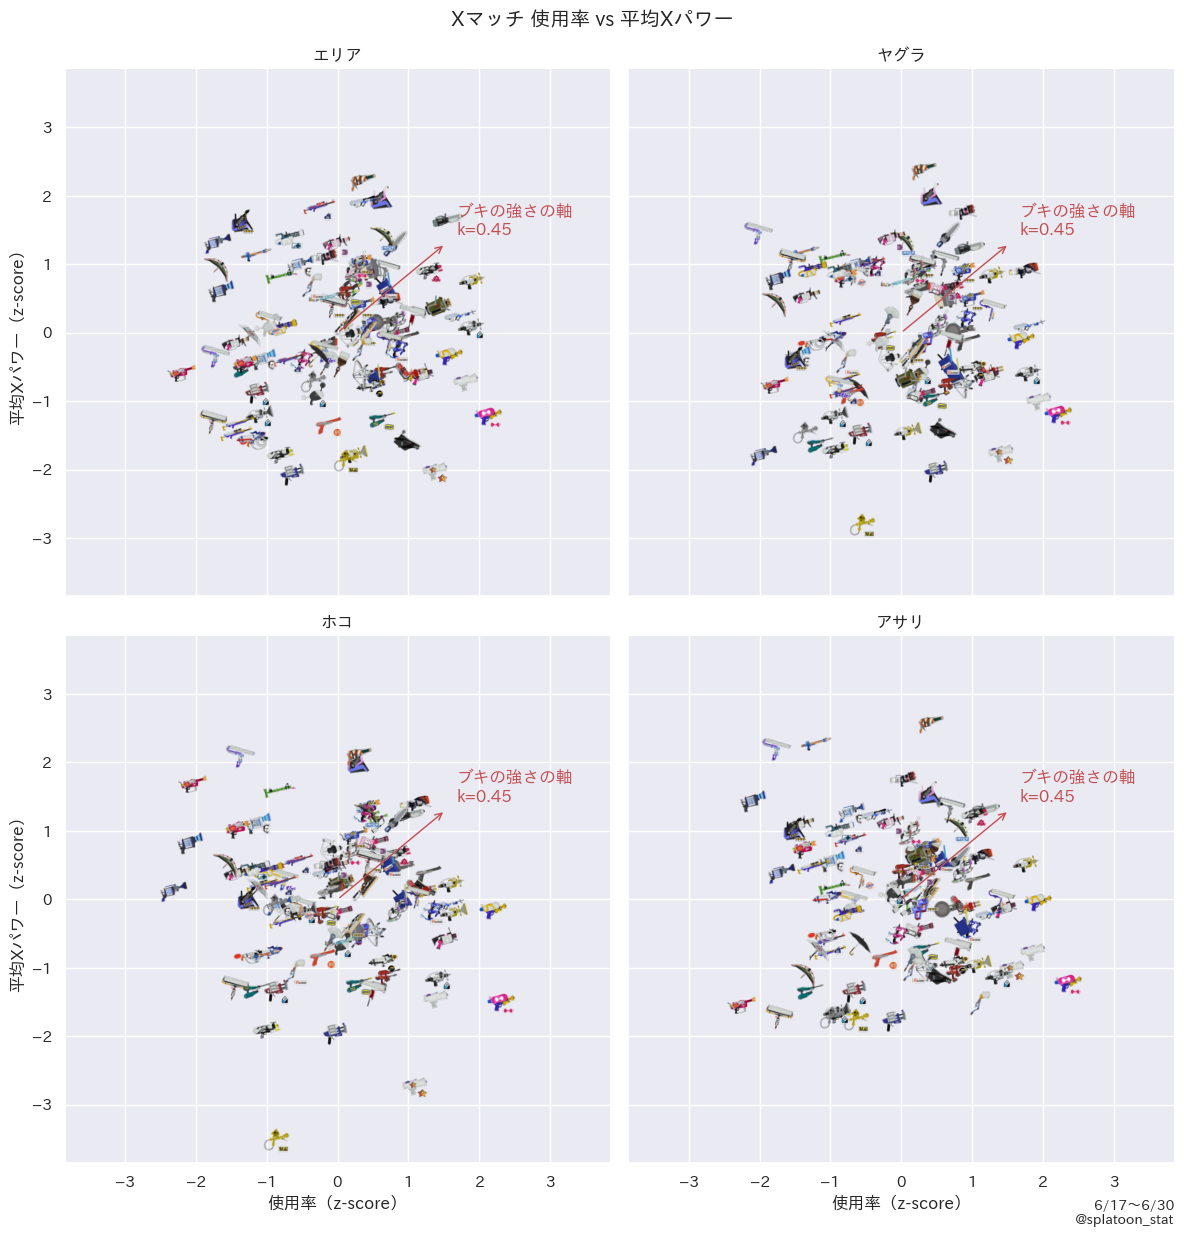

In [30]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("usage", "使用率（z-score）", "Usage (z-score)")
i18n.add("power", "平均Xパワー（z-score）", "X Power Avg. (z-score)")
i18n.add("vector", "ブキの強さの軸", "Assumed axis\nof weapon strength")
i18n.add("title", "${lobby} 使用率 vs 平均Xパワー", "Usage vs X Power Avg. in ${lobby}")

value_range = max(weapon_stat[["usage-z", "power-z"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=weapon_stat,
    x="usage-z",
    y="power-z",
    col="mode",
    col_wrap=2,
    col_order=d.MODE_ORDER,
    marker="",
    height=6,
)
g.fig.suptitle(
    i18n.t("title", lobby=i18n.t(lobby.value)),
    verticalalignment="bottom",
    y=1,
)
g.set(
    xlabel=i18n.t("usage"),
    ylabel=i18n.t("power"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for i, ax in enumerate(g.axes):
    mode = d.MODE_ORDER[i]
    ax.set(title=i18n.t(mode))

    for _, row in weapon_stat.loc[mode].iterrows():
        weapon = row.name
        xvalue = row["usage-z"]
        yvalue = row["power-z"]
        image_path = image.get_image_path(weapon)
        im = plt.imread(image_path)
        img = OffsetImage(im, zoom=0.65)
        img.image.axes = ax
        ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
        ax.add_artist(ab)

    # ブキの強さの軸のベクトルを表示する
    ax.annotate("", (0, 0), xytext=[x * 2 for x in vec_strength], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
    ax.annotate(f"{i18n.t('vector')}\nk={k_coef}", (0, 0), xytext=[x * 2.2 for x in vec_strength], color="r")

    if i == 3:
        u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()

In [31]:
strength_map = weapon_stat.reset_index().pivot(index="weapon", columns="mode", values="strength-t").reindex(d.MODE_ORDER, axis=1)
strength_map["mean"] = strength_map.mean(axis=1)
strength_map = strength_map.sort_values("mean", ascending=False)
strength_map


mode,area,yagura,hoko,asari,mean
weapon,,,,,
kugelschreiber,72.632524,65.447048,65.818458,67.545692,67.860931
bottlegeyser,67.236396,67.892265,66.047433,69.947789,67.780971
sharp,69.467564,65.400473,63.807171,66.958415,66.408406
bucketslosher,67.443830,66.204435,65.207500,63.116971,65.493184
longblaster,58.246638,69.170033,67.366621,62.330156,64.278362
...,...,...,...,...,...
jetsweeper,36.924275,30.897888,32.774281,31.666210,33.065664
carbon,28.223124,45.156077,30.624908,25.781499,32.446402
rapid_elite,29.432264,31.344613,45.377154,22.869714,32.255936


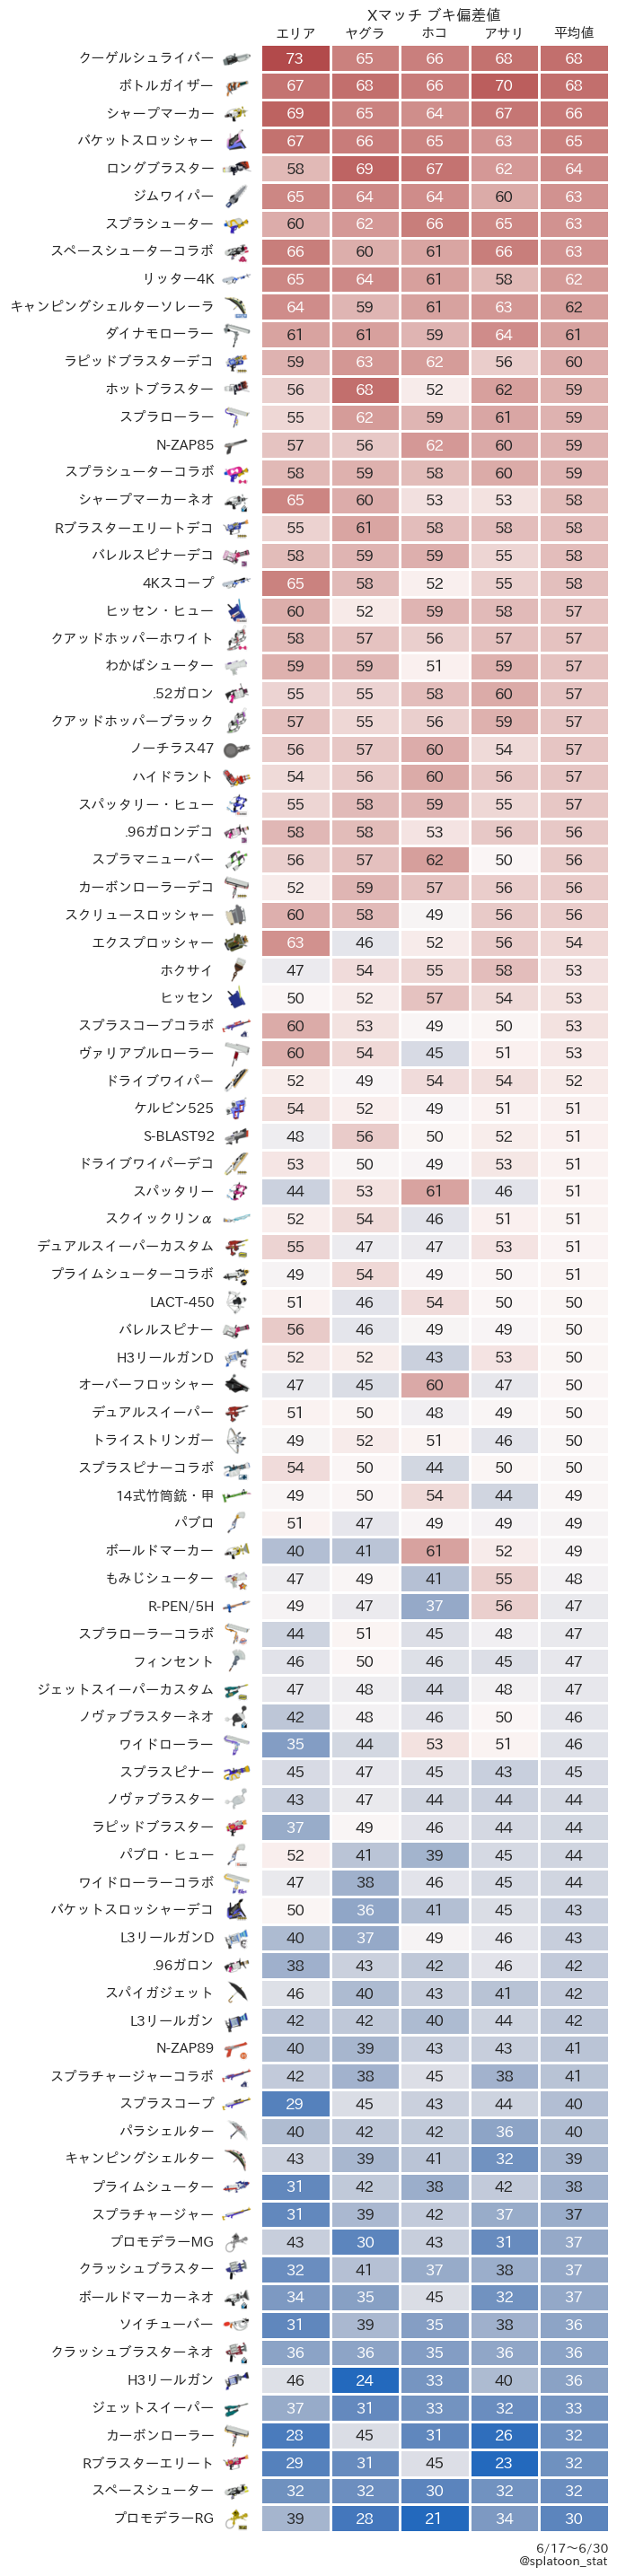

In [32]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("strength", "ブキ偏差値", "Usage Strength (t-score)")
i18n.add("title", "${lobby} ブキ偏差値", "Weapon Strehgth (t-score) in ${lobby}")

fig, ax = plt.subplots(figsize=(5, len(strength_map.index) * 0.4))
sns.heatmap(
    strength_map,
    annot=True,
    fmt=".0f",
    cbar=False,
    cmap=sns.color_palette("vlag", as_cmap=True),
    center=50,
    vmin=50-25,
    vmax=50+25,
    linewidths=2,
    ax=ax,
)

xkeys, ykeys = u.get_ax_ticklabels(ax)
xticklabels = [i18n.t(x) for x in xkeys]
yticklabels = [i18n.t(x) for x in ykeys]

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(length=0)

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel="",
    ylabel="",
    xticklabels=xticklabels,
)
ax.yaxis.set_ticklabels(yticklabels, x=-0.12)

for i, key in enumerate(ykeys):
    image_path = image.get_image_path(key)
    img = OffsetImage(plt.imread(image_path), zoom=.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (0, 0), xybox=(-0.35, i + 0.5), frameon=False)
    ax.add_artist(ab)

u.credit(ax, fig, i18n.t_data_duration(battles), .3)

plt.show()